<a href="https://colab.research.google.com/github/serenaHoney/serenaHoney/blob/main/xhjd62_rl_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework Template

**Dependencies and imports**

This can take a minute...

In [ ]:
!pip install swig
!pip install --upgrade rldurham

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import rldurham as rld

device = torch.device("cpu")

## Using a deep, dense D2RL Q-network


In [ ]:
# D2RLQNetwork code implemented from https://github.com/pairlab/d2rl/blob/main/sac/model.py


def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class D2RLQNetwork(nn.Module):
    def __init__(self,
                 num_inputs,
                 num_actions,
                 hidden_dim,
                 num_layers=3):
        super(D2RLQNetwork, self).__init__()

        in_dim = num_inputs + num_actions + hidden_dim
        # Q architecture
        self.l1_1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.l1_2 = nn.Linear(in_dim, hidden_dim)

        if num_layers > 2:
            self.l1_3 = nn.Linear(in_dim, hidden_dim)
            self.l1_4 = nn.Linear(in_dim, hidden_dim)

        if num_layers > 4:
            self.l1_5 = nn.Linear(in_dim, hidden_dim)
            self.l1_6 = nn.Linear(in_dim, hidden_dim)

        if num_layers == 8:
            self.l1_7 = nn.Linear(in_dim, hidden_dim)
            self.l1_8 = nn.Linear(in_dim, hidden_dim)

        self.out = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

        self.num_layers = num_layers

    def forward(self, input):
        xu = input

        x1 = F.relu(self.l1_1(xu))
        x1 = torch.cat([x1, xu], dim=1)

        x1 = F.relu(self.l1_2(x1))
        if self.num_layers > 2:
            x1 = torch.cat([x1, xu], dim=1)

        if self.num_layers > 2:
            x1 = F.relu(self.l1_3(x1))
            x1 = torch.cat([x1, xu], dim=1)

            x1 = F.relu(self.l1_4(x1))
            if self.num_layers > 4:
                x1 = torch.cat([x1, xu], dim=1)

        if self.num_layers > 4:
            x1 = F.relu(self.l1_5(x1))
            x1 = torch.cat([x1, xu], dim=1)

            x1 = F.relu(self.l1_6(x1))
            if self.num_layers > 6:
                x1 = torch.cat([x1, xu], dim=1)

        if self.num_layers == 8:
            x1 = F.relu(self.l1_7(x1))
            x1 = torch.cat([x1, xu], dim=1)

            x1 = F.relu(self.l1_8(x1))

        x1 = self.out(x1)

        return x1

    def weights_init_(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight, gain=1)
            torch.nn.init.constant_(m.bias, 0)

D2RL Actor (Gaussian Policy)

In [ ]:
# code implemented from https://github.com/pairlab/d2rl/blob/main/sac/model.py


class D2RLGaussianPolicy(nn.Module):
    def __init__(self,
                 num_inputs,
                 num_actions,
                 maximum_action,
                 hidden_dim,
                 hidden_activation,
                 action_bound_epsilon,
                 log_sig_min,
                 log_sig_max,
                 act_space,
                 num_layers=3,
                 ):
        super(D2RLGaussianPolicy, self).__init__()
        self.num_layers = num_layers
        self.action_bound_epsilon = action_bound_epsilon
        self.log_sig_min = log_sig_min
        self.log_sig_max = log_sig_max

        in_dim = hidden_dim+num_inputs
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(in_dim, hidden_dim)


        if num_layers > 2:
            self.linear3 = nn.Linear(in_dim, hidden_dim)
            self.linear4 = nn.Linear(in_dim, hidden_dim)
        if num_layers > 4:
            self.linear5 = nn.Linear(in_dim, hidden_dim)
            self.linear6 = nn.Linear(in_dim, hidden_dim)
        if num_layers == 8:
            self.linear7 = nn.Linear(in_dim, hidden_dim)
            self.linear8 = nn.Linear(in_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

        # action rescaling
        if act_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (act_space.high - act_space.low) / 2.).to(device)
            self.action_bias = torch.FloatTensor(
                (act_space.high + act_space.low) / 2.).to(device)

    def forward(self, state, deterministic=False,
        with_log_prob=True,):
        x = F.relu(self.linear1(state))
        x = torch.cat([x, state], dim=1)

        x = F.relu(self.linear2(x))

        if self.num_layers > 2:
            x = torch.cat([x, state], dim=1)
            x = F.relu(self.linear3(x))

            x = torch.cat([x, state], dim=1)
            x = F.relu(self.linear4(x))

        if self.num_layers > 4:
            x = torch.cat([x, state], dim=1)
            x = F.relu(self.linear5(x))

            x = torch.cat([x, state], dim=1)
            x = F.relu(self.linear6(x))

        if self.num_layers == 8:
            x = torch.cat([x, state], dim=1)
            x = F.relu(self.linear7(x))

            x = torch.cat([x, state], dim=1)
            x = F.relu(self.linear8(x))

        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=self.log_sig_min, max=self.log_sig_max)
        std = log_std.exp()
        normal = Normal(mean, std)

        if deterministic:
            pre_tanh_value = mean
            action = torch.tanh(mean)
        else:
            pre_tanh_value = normal.rsample()
            action = torch.tanh(pre_tanh_value)

        if with_log_prob:
            log_prob = normal.log_prob(pre_tanh_value)
            log_prob -= torch.log(self.action_scale * (1 - action.pow(2)) + self.action_bound_epsilon)
            log_prob = log_prob.sum(1, keepdim=True)
        else:
            log_prob = None

        # Scale the actions
        action = action * self.action_scale + self.action_bias
        mean = torch.tanh(mean) * self.action_scale + self.action_bias

        return (action, mean, log_std, log_prob, std, pre_tanh_value)

    def weights_init_(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight, gain=1)
            torch.nn.init.constant_(m.bias, 0)


## Replay buffer

In [ ]:
# code implemented from https://github.com/watchernyu/REDQ/blob/main/redq/algos/core.py

class ExperienceReplay:
    def __init__(
        self,
        observation_space,
        action_space,
        size
    ):

        self.observation_space = observation_space
        self.action_space = action_space
        self.observation_1_buffer = np.zeros([size, self.observation_space], dtype=np.float32)
        self.observation_2_buffer = np.zeros([size, self.observation_space], dtype=np.float32)
        self.actions_buffer = np.zeros([size, self.action_space], dtype=np.float32)
        self.rewards_buffer = np.zeros(size, dtype=np.float32)
        self.done_buffer = np.zeros(size, dtype=np.float32)
        self.position = 0
        self.size = 0
        self.max_size = size

    def store(
        self,
        observation,
        action,
        reward,
        next_observation,
        done
    ):

        self.observation_1_buffer[self.position] = observation
        self.observation_2_buffer[self.position] = next_observation
        self.actions_buffer[self.position] = action
        self.rewards_buffer[self.position] = reward
        self.done_buffer[self.position] = done

        self.position = (self.position + 1) % self.max_size

        self.size = min(self.size + 1, self.max_size)


    def sample_batch(
        self,
        batch_size,
        idxs=None
    ):
        if idxs is None:
            idxs = np.random.randint(0, self.size, size=batch_size)

        return dict(observation_1=self.observation_1_buffer[idxs],
                    observation_2=self.observation_2_buffer[idxs],
                    actions=self.actions_buffer[idxs],
                    rewards=self.rewards_buffer[idxs],
                    done=self.done_buffer[idxs],
                    idxs=idxs
                )

**Reinforcement learning agent**

Agent REDQ-SAC.

In [ ]:
# code implemented from https://github.com/watchernyu/REDQ/blob/main/redq/algos/redq_sac.py

class Agent(nn.Module):
    def __init__(
        self,
        observation_space,
        action_space,
        maximum_action,
        hidden_dimensions,
        hidden_activation,
        action_bound_epsilon,
        log_sig_min,
        log_sig_max,
        N,
        M,
        G,
        replay_size,
        batch_size,
        alpha,
        gamma,
        polyak,
        random_action_steps,
        policy_update_delay,
        learning_rate,
        device
    ):
        super().__init__()

        self.observation_space = observation_space
        self.action_space = action_space
        self.maximum_action = maximum_action
        self.hidden_dimensions = hidden_dimensions
        self.hidden_activation = hidden_activation
        self.action_bound_epsilon = action_bound_epsilon
        self.log_sig_min = log_sig_min
        self.log_sig_max = log_sig_max

        self.N = N
        self.M = M
        self.G = G

        self.replay_size = replay_size
        self.batch_size = batch_size

        self.alpha = alpha
        self.gamma = gamma
        self.polyak = polyak

        self.random_action_steps = random_action_steps
        self.delay_update_steps = self.random_action_steps
        self.policy_update_delay = policy_update_delay
        self.target_entropy = -self.maximum_action

        self.learning_rate = learning_rate
        self.device = device


        # NETWORKS
        self.policy_network = D2RLGaussianPolicy(
            num_inputs=self.observation_space,
            num_actions=self.action_space,
            maximum_action=self.maximum_action,
            hidden_dim=self.hidden_dimensions,
            hidden_activation=self.hidden_activation,
            action_bound_epsilon=self.action_bound_epsilon,
            log_sig_min=self.log_sig_min,
            log_sig_max=self.log_sig_max,
            act_space=env.action_space,
        ).to(device)


        self.q_networks_list, self.q_target_networks_list = [], []
        for q_i in range(self.N):
            new_q_net = D2RLQNetwork(
                num_inputs=self.observation_space,
                num_actions=self.action_space,
                hidden_dim=self.hidden_dimensions,
            ).to(device)
            self.q_networks_list.append(new_q_net)

            new_q_target_network = D2RLQNetwork(
                num_inputs=self.observation_space,
                num_actions=self.action_space,
                hidden_dim=self.hidden_dimensions,
            ).to(device)
            new_q_target_network.load_state_dict(new_q_net.state_dict())
            self.q_target_networks_list.append(new_q_target_network)

        # OPTIMIZERS
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.q_optimizer_list = []
        for q_i in range(self.N):
            self.q_optimizer_list.append(optim.Adam(self.q_networks_list[q_i].parameters(), lr=self.learning_rate))


        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=self.learning_rate)
        self.alpha = self.log_alpha.cpu().exp().item()

        # EXPERIENCE REPLAY
        self.experience_replay = ExperienceReplay(
            observation_space=self.observation_space,
            action_space=self.action_space,
            size=self.replay_size
        )

        # LOSS
        self.loss = nn.MSELoss()


    def __get_current_num_data(self):
        return self.experience_replay.size


    def get_exploration_action(
        self,
        observation,
        env
    ):
        with torch.no_grad():
            if self.__get_current_num_data() > self.random_action_steps:
                observation_tensor = torch.Tensor(observation).unsqueeze(0).to(self.device)
                action_tensor = self.policy_network.forward(observation_tensor, deterministic=False, with_log_prob=False)[0]
                action = action_tensor.cpu().numpy().reshape(-1)
            else:
                action = env.action_space.sample()
        return action

    def get_test_action(
        self,
        observation
    ):
        with torch.no_grad():
            observation_tensor = torch.Tensor(observation).unsqueeze(0).to(self.device)
            action_tensor = self.policy_network.forward(observation_tensor, deterministic=True, with_log_prob=False)[0]
            action = action_tensor.cpu().numpy().reshape(-1)
        return action


    def get_action_and_logprob_for_bias_evaluation(
        self,
        observation
    ):
        with torch.no_grad():
            observation_tensor = torch.Tensor(observation).unsqueeze(0).to(self.device)
            action_tensor, _, _, log_prob_a_tilda, _, _, = self.policy_network.forward(observation_tensor, deterministic=False, with_log_prob=True)
            action = action_tensor.cpu().numpy().reshape(-1)
        return action, log_prob_a_tilda


    def get_ave_q_prediction_for_bias_evaluation(
        self,
        observation_tensor,
        actions_tensor
    ):
        q_prediction_list = []
        for q_i in range(self.N):
            q_prediction = self.q_networks_list[q_i](torch.cat([observation_tensor, actions_tensor], 1))
            q_prediction_list.append(q_prediction)
        q_prediction_cat = torch.cat(q_prediction_list, dim=1)
        average_q_prediction = torch.mean(q_prediction_cat, dim=1)
        return average_q_prediction


    def store_data(
        self,
        observation,
        action,
        reward,
        new_observation,
        done
    ):
        self.experience_replay.store(observation, action, reward, new_observation, done)


    def sample_data(
        self,
        batch_size
    ):
        batch = self.experience_replay.sample_batch(batch_size)
        observation_tensor = torch.Tensor(batch["observation_1"]).to(self.device)
        observation_next_tensor = torch.Tensor(batch["observation_2"]).to(self.device)
        actions_tensor = torch.Tensor(batch["actions"]).to(self.device)
        rewards_tensor = torch.Tensor(batch["rewards"]).unsqueeze(1).to(self.device)
        done_tensor = torch.Tensor(batch["done"]).unsqueeze(1).to(self.device)
        return observation_tensor, observation_next_tensor, actions_tensor, rewards_tensor, done_tensor


    def get_probabilistic_Ms(
        self,
        Ms
    ):
        floored_Ms = np.floor(Ms)
        if Ms - floored_Ms > 0.001:
            prob_for_higher_value = Ms - floored_Ms
            if np.random.uniform(0, 1) < prob_for_higher_value:
                return int(floored_Ms + 1)
            else:
                return int(floored_Ms)
        else:
            return Ms


    def get_redq_q_target_no_grad(
        self,
        observation_next_tensor,
        rewards_tensor,
        done_tensor
    ):

        Ms_to_use = self.get_probabilistic_Ms(self.M)
        sample_idxs = np.random.choice(self.N, Ms_to_use, replace=False)

        with torch.no_grad():
            a_tilda_next, _, _, log_prob_a_tilda_next, _, _ = self.policy_network.forward(observation_next_tensor)
            q_prediction_next_list = []
            for sample_idx in sample_idxs:
                q_prediction_next = self.q_target_networks_list[sample_idx](torch.cat([observation_next_tensor, a_tilda_next], 1))
                q_prediction_next_list.append(q_prediction_next)
            q_prediction_next_cat = torch.cat(q_prediction_next_list, 1)
            min_q, min_indices = torch.min(q_prediction_next_cat, dim=1, keepdim=True)
            next_q_with_log_prob = min_q - self.alpha * log_prob_a_tilda_next
            y_q = rewards_tensor + self.gamma * (1 - done_tensor) * next_q_with_log_prob

        return y_q, sample_idxs


    def polyak_update_target_network(
        self,
        model_a,
        model_b,
        rou
    ):
        for model_a_param, model_b_param in zip(model_a.parameters(), model_b.parameters()):
            model_a_param.data.copy_(rou * model_a_param.data + (1 - rou) * model_b_param.data)


    def train(self):
        num_update = 0 if self.__get_current_num_data() <= self.delay_update_steps else self.G
        for i_update in range(num_update):
            observation_tensor, observation_next_tensor, actions_tensor, rewards_tensor, done_tensor = self.sample_data(self.batch_size)

            # Q LOSS
            y_q, sample_idxs = self.get_redq_q_target_no_grad(observation_next_tensor, rewards_tensor, done_tensor)
            q_prediction_list = []
            for q_i in range(self.N):
                q_prediction = self.q_networks_list[q_i](torch.cat([observation_tensor, actions_tensor], 1))
                q_prediction_list.append(q_prediction)
            q_prediction_cat = torch.cat(q_prediction_list, dim=1)
            y_q = y_q.expand((-1, self.N)) if y_q.shape[1] == 1 else y_q
            q_loss_all = self.loss(q_prediction_cat, y_q) * self.N

            for q_i in range(self.N):
                self.q_optimizer_list[q_i].zero_grad()
            q_loss_all.backward()

            # POLICY LOSS
            if ((i_update + 1) % self.policy_update_delay == 0) or i_update == num_update - 1:
                # get policy loss
                a_tilda, mean_a_tilda, log_std_a_tilda, log_prob_a_tilda, _, pretanh = self.policy_network.forward(observation_tensor)
                q_a_tilda_list = []
                for sample_idx in range(self.N):
                    self.q_networks_list[sample_idx].requires_grad_(False)
                    q_a_tilda = self.q_networks_list[sample_idx](torch.cat([observation_tensor, a_tilda], 1))
                    q_a_tilda_list.append(q_a_tilda)
                q_a_tilda_cat = torch.cat(q_a_tilda_list, 1)
                ave_q = torch.mean(q_a_tilda_cat, dim=1, keepdim=True)
                policy_loss = (self.alpha * log_prob_a_tilda - ave_q).mean()
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                for sample_idx in range(self.N):
                    self.q_networks_list[sample_idx].requires_grad_(True)

                # ALPHA LOSS
                alpha_loss = -(self.log_alpha * (log_prob_a_tilda + self.target_entropy).detach()).mean()
                self.alpha_optim.zero_grad()
                alpha_loss.backward()
                self.alpha_optim.step()
                self.alpha = self.log_alpha.cpu().exp().item()


            for q_i in range(self.N):
                self.q_optimizer_list[q_i].step()

            if ((i_update + 1) % self.policy_update_delay == 0) or i_update == num_update - 1:
                self.policy_optimizer.step()

            for q_i in range(self.N):
                self.polyak_update_target_network(self.q_target_networks_list[q_i], self.q_networks_list[q_i], self.polyak)

Hyperparameters and settings

In [ ]:
# Hyperparameters and settings
hidden_dimensions = 256 # (256, 256) # Tuple of integers representing the number of neurons in each hidden layer of the neural networks
hidden_activation = F.relu # Activation function used for the hidden layers of the neural networks
action_bound_epsilon = 0.000001 # A small number used to prevent division by zero
log_sig_min = -20 # The minimum value for the logarithm of the standard deviation of the action distribution
log_sig_max = 2 # The maximum value for the logarithm of the standard deviation of the action distribution

N = 5 # The number of Q-networks used for the REDQ algorithm
M = 2 # The number of Q-values used for the REDQ algorithm at each iteration
G = 10 # The ratio of updates to environment steps used for the REDQ algorithm

replay_size = 1_000_000 # The size of the replay buffer used for experience replay
batch_size = 256 # The number of samples taken from the replay buffer for each training iteration

random_action_steps = 4_000 # The number of steps during which the agent takes random actions
policy_update_delay = 40 # The frequency with which the policy network is updated

alpha = 0.2 # The temperature parameter used for the policy's entropy term
gamma = 0.99 # The discount factor for future rewards
polyak = 0.995 # The polyak averaging parameter used to update the target networks

learning_rate = 0.0003 # The learning rate used for the optimizer

**Prepare the environment and wrap it to capture statistics, logs, and videos**

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


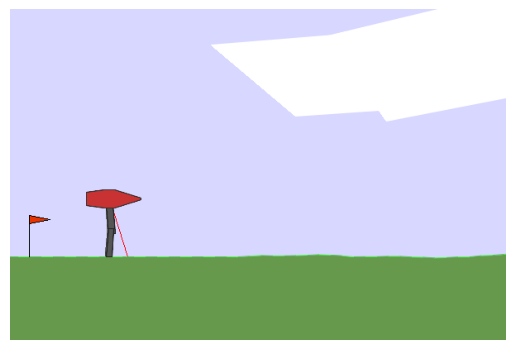

In [ ]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xhjd62-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

In [ ]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [ ]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]
maximum_action = env.action_space.high[0].item()

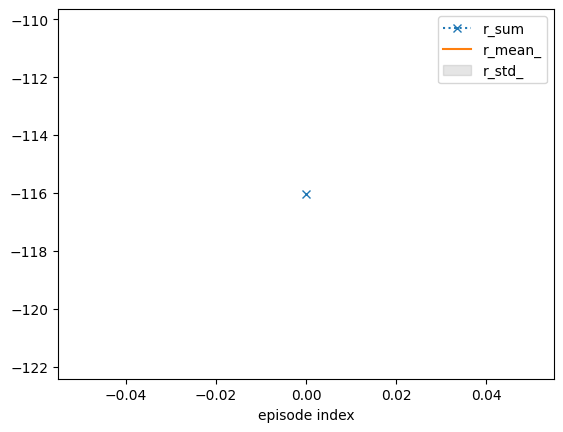

In [ ]:

# initialise agent
agent = Agent(
    observation_space=observation_space,
    action_space=action_space,
    maximum_action=maximum_action,
    hidden_dimensions=hidden_dimensions,
    hidden_activation=hidden_activation,
    action_bound_epsilon=action_bound_epsilon,
    log_sig_min=log_sig_min,
    log_sig_max=log_sig_max,
    N=N,
    M=M,
    G=G,
    replay_size=replay_size,
    batch_size=batch_size,
    alpha=alpha,
    gamma=gamma,
    polyak=polyak,
    random_action_steps=random_action_steps,
    policy_update_delay=policy_update_delay,
    learning_rate=learning_rate,
    device=device
)
max_episodes = 100
max_timesteps = 2000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

# training procedure
for episode in range(max_episodes+1):

    # recording statistics and video can be switched on and off (video recording is slow!)
    env.info = episode % 10 == 0   # track every x episodes (usually tracking every episode is fine)
    env.video = episode % 10 == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()

    # run episode
    for t in range(max_timesteps):

        # select the agent action
        # action = agent.sample_action(observation)
        action = agent.get_exploration_action(observation, env)

        # take action in the environment
        # next_observation, reward, done, _ = env.step(action)
        next_observation, reward, terminated, truncated, info = env.step(action)

        # check whether done
        done = terminated or truncated

        # remember
        agent.store_data(observation, action, reward, next_observation, done)

        # Set observation to next observation
        observation = next_observation

        agent.train()

        # stop episode
        if done:
            break
    # write log file (for coursework)
    env.write_log(folder="logs", file="xhjd62-agent-log.txt")  # replace xxxx00 with your username

    # TRAIN THE AGENT HERE!

    # track and plot statistics
    tracker.track(info)
    # if (episode + 1) % 10 == 0:
    tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
env.write_log(folder="logs", file="xhjd62-agent-log.txt")  # replace xxxx00 with your username

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

At some I will need to save the model to then reload it and continue training. More info on how to do this here: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [ ]:
# will need to save model at some point to then reload and continue training
# torch.save(model.state_dict(), "model.pth")
# print("Saved PyTorch Model State to model.pth")

# loading the model
# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth", weights_only=True))

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...